In [1]:
# Importation des packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Etude d'un modèle de decision (kNN) sur la qualité du vin 

In [2]:
data = pd.read_csv(r'L:qualitedevin.csv', sep=';')
print(data.head(2))
data.shape

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70          0.0             1.9      0.076   
1            7.8              0.88          0.0             2.6      0.098   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   

   alcohol  quality  
0      9.4        5  
1      9.8        5  


(1599, 12)

Input variables (based on physicochemical tests):
1 - fixed acidity  
2 - volatile acidity  
3 - citric acid  
4 - residual sugar  
5 - chlorides  
6 - free sulfur dioxide  
7 - total sulfur dioxide  
8 - density  
9 - pH  
10 - sulphates  
11 - alcohol  
Output variable (based on sensory data):  12 - quality (score between 0 and 10)

For more information, read <a hred="https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377?via%3Dihub">Cortez et al., 2009<\a>

------------------

#### Partie I : Utilisation du modèle kNN et choix du meilleur nombre de voisins

In [3]:
# Extractiond des données sous forme d'"arrays"
X = data[data.columns[:-1]].values # matrice X
print(X.shape)
print(X[1520])

(1599, 11)
[ 6.5      0.53     0.06     2.       0.063   29.      44.       0.99489
  3.38     0.83    10.3    ]


In [4]:
y = data['quality'].values # vecteur y
print(y.shape)

(1599,)


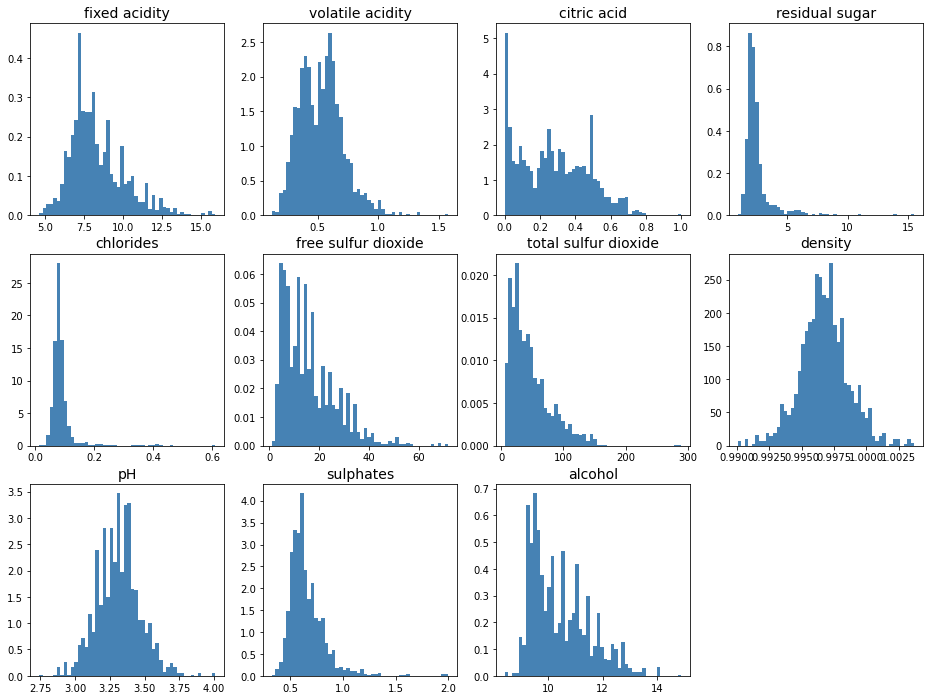

In [5]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none') 
    # hisogramme pour chaque feature
    ax.set_title(data.columns[feat_idx], fontsize=14)

Les features varient de 1 à 300. Standardiser les feature permettra de ne pas être dominé par "total sulfur dioxide" 

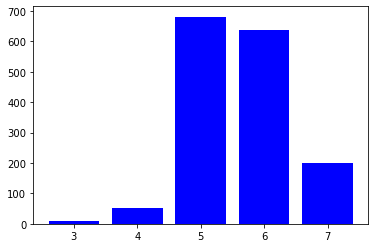

In [6]:
# les valeurs de qualité sont comprise entre 3 et 7
qua = range(np.min(y), np.max(y))
b = plt.bar(qua, [(y == a).sum() for a in qua], color=('blue'))

In [7]:
# On peut ici définir un bon vin (note de qualité supérieur à 6)
y_class = np.where(y<6, 0, 1)

In [8]:
print(y_class[y_class==1].shape)

(855,)


In [9]:
print(y_class[y_class==0].shape)

(744,)


In [10]:
#split entrainement/test
from sklearn import model_selection

In [11]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y_class,
                                    test_size=0.3 # 30% des données dans le jeu de test
                                    )

In [12]:
# standardisation avec scikit
from sklearn import preprocessing

In [13]:
std_scale = preprocessing.StandardScaler().fit(X_train) # standardiseur avec paramètre sur jeu d'entrainement
# entrainement et test avec le sclaleur
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

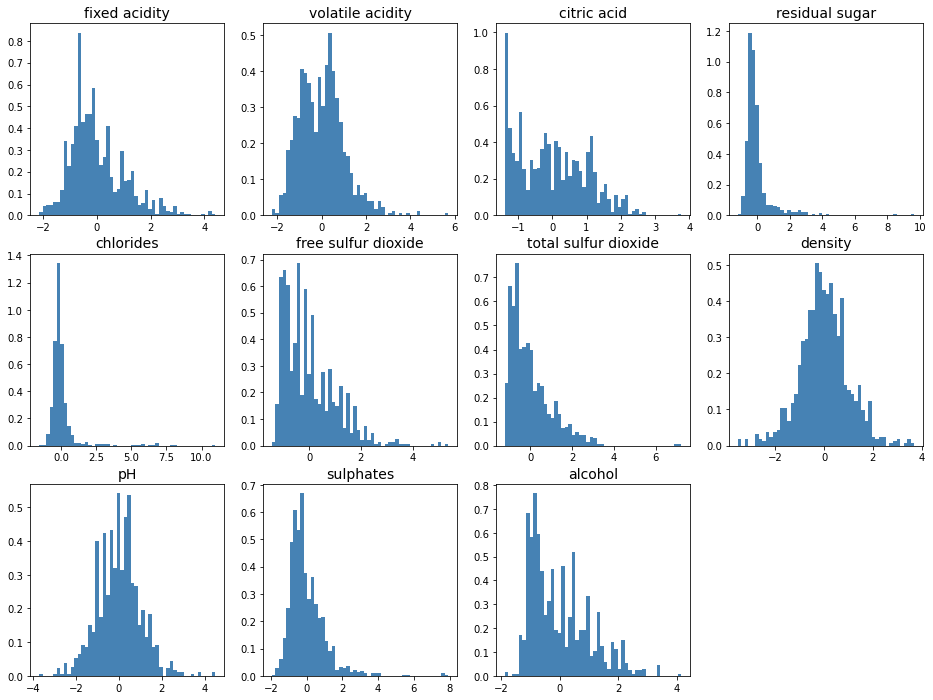

In [14]:
# same plot avec les valeurs standardisées pour vérifier les distributions (x --> X_train_std)
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

On des valeurs dans la même échelle

In [15]:
# On utilise un modèle kNN
from sklearn import neighbors, metrics

In [16]:
# On choisi le scoire à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# et on effectue un comparatif hyperparamétrique / méthode force brute
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

In [17]:
# Classifieur kNN avec recherche d'hyperparamètre par validation croisée sans stratification
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur basé sur le modèle des plus proches voisins (kNN)
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

In [18]:
# Optimisation du classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15]},
             scoring='accuracy')

In [19]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}


L'hyperparamètre avec la meilleure "accuracy" est 11

In [20]:
# Juste pour vérifier on regarde les performances de tous les hyperparamètres
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Résultats de la validation croisée :
accuracy = 0.714 (+/-0.038) for {'n_neighbors': 3}
accuracy = 0.731 (+/-0.052) for {'n_neighbors': 5}
accuracy = 0.720 (+/-0.074) for {'n_neighbors': 7}
accuracy = 0.733 (+/-0.031) for {'n_neighbors': 9}
accuracy = 0.733 (+/-0.038) for {'n_neighbors': 11}
accuracy = 0.728 (+/-0.047) for {'n_neighbors': 13}
accuracy = 0.734 (+/-0.047) for {'n_neighbors': 15}


11 est dévant mais talonné par k = 13 et 15

In [21]:
# perf de l'algo sur le jeu de test avec k = 9
# GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement
y_pred = clf.predict(X_test_std)

In [22]:
from sklearn import metrics

In [23]:
print("L\'accuracy sur le jeu de test est de : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

L'accuracy sur le jeu de test est de : 0.748


On est un peu plus bas que sur la validation croisée.  
La perf en validation croisée du modèle peut être un peut biaiser par rapport au jeu de test extérieur donc pas de problème ici.

In [24]:
# courbe ROC "Receiver-Operator Characteristic"
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
# frp = false positive rate
# tpr = true positive rate
# thr = thresholds

plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (antispécificité)', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14);

In [25]:
# AUROC (1 = parfait) 
print(metrics.auc(fpr, tpr))

0.8123902044831706


Dans le cas d'un vin, on cherche à minisimer le nombre de faux négatif (vin qui seront mis de côté parce que mauvais).  
On fixe le seuil à 5%, ce qui équivaut à une sensibilité de 0.95

In [26]:
# indice du premier seuil pour lequel la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Utiliser un seuil de {:.2f}".format(thr[idx]))
print("garantit une sensibilité de {:.2f}".format(tpr[idx]))
print("et une spécificité de {:.2f}".format(1-fpr[idx]))

Utiliser un seuil de 0.27
garantit une sensibilité de 0.95
et une spécificité de 0.22


------------------

#### Partie 2 :

Comparation du modèle de régression kNN avec un méthode de régression naïve

In [71]:
# découpage du set d'entrainement et de test
X2_train, X2_test, y2_train, y2_test = \
    model_selection.train_test_split(X, y,
                                    test_size=0.3 # 30% des données dans le jeu de test
                                    )

In [72]:
# standardisation comme dans la partie 1
std_scale = preprocessing.StandardScaler().fit(X2_train)
X2_train_std = std_scale.transform(X2_train)
X2_test_std = std_scale.transform(X2_test)

In [73]:
mkNN = neighbors.KNeighborsRegressor(n_neighbors = 11)

In [74]:
# Entrainement du modèle sur le set de test
mkNN.fit(X2_train_std, y2_train)

KNeighborsRegressor(n_neighbors=11)

In [75]:
y2_pred = mkNN.predict(X2_test_std)

In [76]:
print("RMSE : {:.2f}".format(np.sqrt( metrics.mean_squared_error(y2_test, y2_pred) ))) # root(metrics.MSE)

RMSE : 0.68


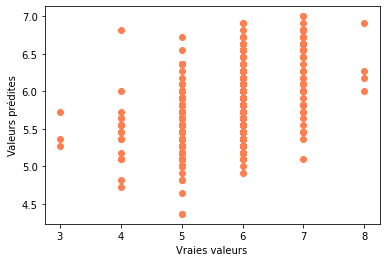

In [85]:
axes = plt.axes()
plt.scatter(y2_test, y2_pred, color='coral')
axes.set(xlabel="Vraies valeurs", ylabel="Valeurs prédites");

Pour mieux visualiser les données qui présentent de nombreuses superpositions, il est plus judicieux d'utiliser comme marqueurs des cercles dont la taille est proportionnelle au nombre de points.

In [86]:
# Comptabilisation des paires dans le dictionnaires sizes
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y2_test), list(y2_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

# chaque clés aura la taille correspondante
keys = sizes.keys()

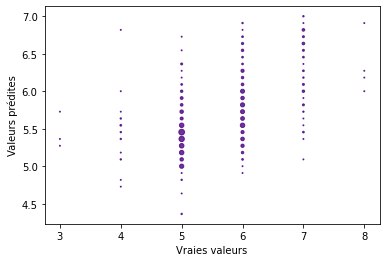

In [87]:
axes = plt.axes()
plt.scatter(
        [k[0] for k in keys], # vraie valeur (abscisse)
        [k[1] for k in keys], # valeur predite (ordonnee)
        s=[sizes[k] for k in keys], # taille du marqueur
        color='indigo', alpha =0.8)
axes.set(xlabel="Vraies valeurs", ylabel="Valeurs prédites");

On note ainsi une accumulation de prédictions correctes sur la diagonale (vraies valeurs). Néanmoins le modèle n'est pas très précis dans ses prédictions.

Est-il plus précis qu'un modèle dit *naïf*
Faisons une comparaison avec la RMSE

----------------

a) valeurs aléatoires :

In [79]:
# création d'une modèle de valeurs aléatoire variant des valeurs mins et max d'y
y2_pred_random = np.random.randint(np.min(y2), np.max(y2), y2_test.shape)

In [80]:
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, y2_pred_random))))

RMSE : 1.75


La RMSE du modèle naïf est bien plus élevée que celle des kNN voisins. Le modèle naïf est donc moins précis

-----------

b) valeurs constantes (moyenne)

In [88]:
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='mean') # la valeur constante du modèle sera la valeur moyenne

In [82]:
# Entraînement
dum.fit(X2_train_std, y2_train)

# Prédiction sur le jeu de test
y2_pred_dum = dum.predict(X2_test_std)

In [83]:
# Evaluation
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y2_test, y2_pred_dum)) ))

RMSE : 0.80


On a cette fois-ci une RMSE de 0.80. L'algorithme des k plus proches voisins *apprend* donc mieux que des modèles naïfs. 
Néanmoins, on voit qu'il ne donne pas de très bons modèles sur ce problème...